<a href="https://colab.research.google.com/github/sondisonda/covid19SpreadForecast/blob/master/covid19SpreadForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing data from github


In [ ]:
import pandas as pd
path='https://raw.githubusercontent.com/sondisonda/covid19SpreadForecast/master/enriched_covid_19_week_2.csv'

df = pd.read_csv(path)
df.shape

(18816, 38)

In [ ]:
df.drop(['Id'], 1, inplace=True)
df.drop(['Province_State'], 1, inplace=True)
df.drop(['Date'], 1, inplace=True)


In [ ]:
# Pick a few countries to get an overview

spain =  df[df.Country_Region == 'Spain']
italy =  df[df.Country_Region == 'Italy']
france =  df[df.Country_Region == 'France']
belgium =  df[df.Country_Region == 'Belgium']
uk =  df[df.Country_Region == 'United Kingdom']
germany =  df[df.Country_Region == 'Germany']

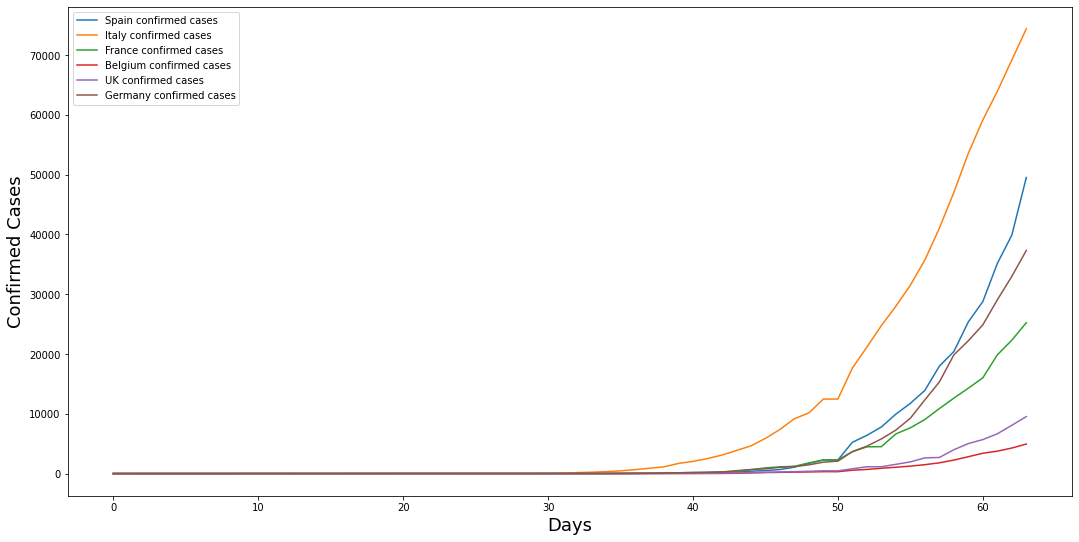

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(range(spain.shape[0]),spain['ConfirmedCases'],\
         label="Spain confirmed cases")
plt.plot(range(italy.shape[0]),italy['ConfirmedCases'],\
         label="Italy confirmed cases")
plt.plot(range(france.shape[0]),france['ConfirmedCases'],\
         label="France confirmed cases")
plt.plot(range(belgium.shape[0]),belgium['ConfirmedCases'],\
         label="Belgium confirmed cases")
plt.plot(range(uk.shape[0]),uk['ConfirmedCases'],\
         label="UK confirmed cases")
plt.plot(range(germany.shape[0]),germany['ConfirmedCases'],\
         label="Germany confirmed cases")
plt.xlabel('Days',fontsize=18)
plt.ylabel('Confirmed Cases',fontsize=18)
plt.legend(loc="upper left")
plt.show()

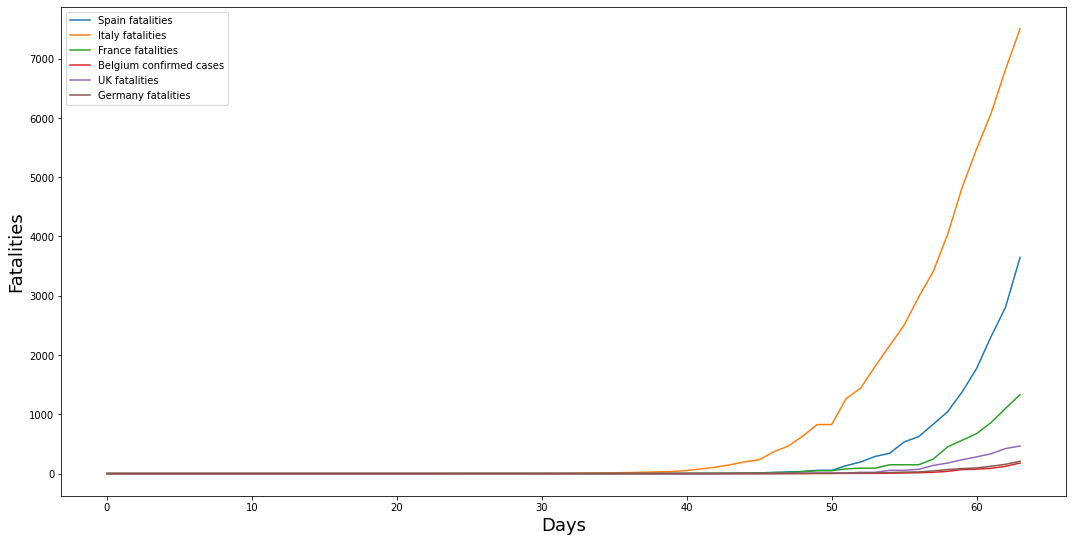

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(spain.shape[0]),spain['Fatalities'],\
         label="Spain fatalities")
plt.plot(range(italy.shape[0]),italy['Fatalities'],\
         label="Italy fatalities")
plt.plot(range(france.shape[0]),france['Fatalities'],\
         label="France fatalities")
plt.plot(range(belgium.shape[0]),belgium['Fatalities'],\
         label="Belgium confirmed cases")
plt.plot(range(uk.shape[0]),uk['Fatalities'],\
         label="UK fatalities")
plt.plot(range(germany.shape[0]),germany['Fatalities'],\
         label="Germany fatalities")
plt.xlabel('Days',fontsize=18)
plt.ylabel('Fatalities',fontsize=18)
plt.legend(loc="upper left")
plt.show()

In [ ]:
lines_count = df.shape[0]
lines_per_country = 64

country_count = int(lines_count / lines_per_country)
train_country_count = int(country_count * (2/3))
test_country_count = int(country_count * (1/3))

train_rows_count = int(lines_count * (2/3))
test_rows_count = int(lines_count * (1/3))

print('Country count: ' + str(country_count))
print('Train rows count: ' + str(train_rows_count))
print('Test rows count: ' + str(test_rows_count))
print('Train country count: ' + str(train_country_count))
print('Test country count: ' + str(test_country_count))

Country count: 294
Train rows count: 12544
Test rows count: 6272
Train country count: 196
Test country count: 98


In [ ]:
# There are 18816 lines
# each country is made up of 64 lines

simplified_df = df[['ConfirmedCases','total_pop']]

simplified_df.shape

(18816, 2)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import array

# Normalize

scaler = MinMaxScaler()

reshaped = array(simplified_df.ConfirmedCases.values).reshape(-1, 1)
scaler.fit(reshaped)
print(scaler.data_max_)
print(scaler.data_min_)
normalized = scaler.transform(reshaped)
simplified_df['ConfirmedCases'] = normalized

reshaped = array(simplified_df.total_pop.values).reshape(-1, 1)
scaler.fit(reshaped)
print(scaler.data_max_)
print(scaler.data_min_)
normalized = scaler.transform(reshaped)
simplified_df['total_pop'] = normalized

simplified_df.describe()

[1.]
[0.]
[1.]
[0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ConfirmedCases,total_pop
count,18816.000000,18816.000000
mean,0.004613,0.172518
std,0.048129,0.310446
min,0.000000,0.000000
25%,0.000000,0.006149
50%,0.000000,0.025867
75%,0.000202,0.232174
max,1.000000,1.000000


In [ ]:
x_train = simplified_df.head(train_rows_count)
x_test = simplified_df.tail(test_rows_count)


In [ ]:
y_train = x_train['ConfirmedCases']
y_test = x_test['ConfirmedCases']

In [ ]:
x_days_train = list()
y_days_train = list()
length = lines_per_country
country_count = train_country_count
for i in range(0,length*country_count,length):
    x_day_train = x_train[i:i+length-1]
    x_days_train.append(x_day_train.values)
    y_day_train = y_train[i+length-1:i+length]
    y_days_train.append(y_day_train.values)
print(len(x_days_train))
print(len(y_days_train))

196
196


In [ ]:

import numpy as np
from numpy import array

# The LSTM needs data with the format of [samples, time steps and features]
# Here, we have 196 samples, 63 time steps per sample, and 2 features
# First, we need to convert our list of arrays into a 2D NumPy array of 196 x 2

# convert list of arrays into 2d array
x_train = array(x_days_train)
print(x_train.shape)
y_train = array(y_days_train)
print(y_train.shape)

(196, 63, 2)
(196, 1)


In [ ]:
# Next, we can use the reshape() function 
# to add one additional dimension for our features

# reshape into [samples, timesteps, features]
# expect [196, 63, 2]

x_train = x_train.reshape(train_country_count, 63, 2)
print(x_train.shape)

(196, 63, 2)


In [ ]:
# Create test set

x_days_test = list()
y_days_test = list()
length = lines_per_country
country_count = test_country_count
for i in range(0,length*country_count,length):
    x_day_test = x_test[i:i+length-1]
    x_days_test.append(x_day_test.values)
    y_day_test = y_test[i+length-1:i+length]
    y_days_test.append(y_day_test.values)
print(len(x_days_test))
print(len(y_days_test))

x_test = array(x_days_test)
print(x_test.shape)
y_test = array(y_days_test)
print(y_test.shape)

x_test = x_test.reshape(test_country_count, 63, 2)
print(x_test.shape)

98
98
(98, 63, 2)
(98, 1)
(98, 63, 2)


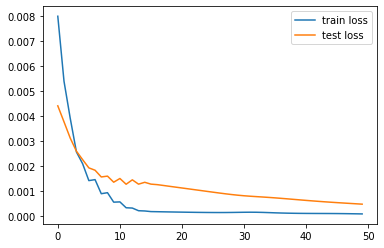

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

from matplotlib import pyplot

# Define model
n_steps = 63
n_features = 2
n_batch = 4
model = Sequential()
model.add(LSTM(16, input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit network
history = model.fit(x_train, y_train, epochs=50,\
                    batch_size=n_batch, validation_data=(x_test, y_test),\
                    verbose=0, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='test loss')
pyplot.legend()
pyplot.show()

In [ ]:
predictions = model.predict(x_test)


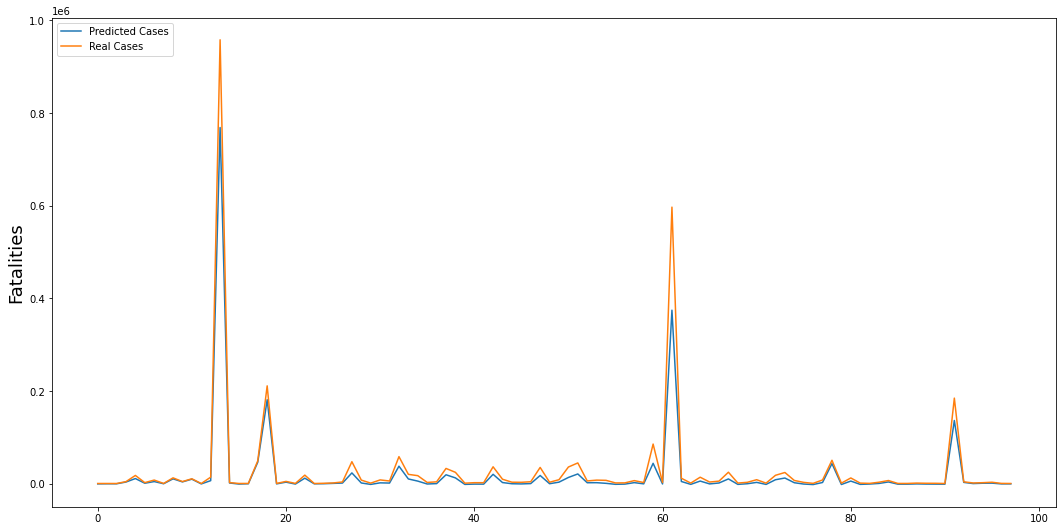

In [ ]:

inversed_pred = scaler.inverse_transform(predictions)
inversed_real = scaler.inverse_transform(y_test)
    
plt.figure(figsize = (18,9))
plt.plot(range(len(inversed_pred)),inversed_pred, label="Predicted Cases")
plt.plot(range(len(inversed_real)),inversed_real, label="Real Cases")
plt.ylabel('Fatalities',fontsize=18)
plt.legend(loc="upper left")
plt.show()